In [ ]:
# https://gallery.exoplanet.codes/en/latest/tutorials/together/

In [ ]:
Putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from Petigura et al. (2016). This is the same system that we fit in the Radial velocity fitting tutorial and we’ll combine that model with the transit model from the Transit fitting tutorial and the Gaussian Process noise model from the Gaussian process models for stellar variability case study.

Datasets and initializations

To get started, let’s download the relevant datasets. First, the transit light curve from Everest:

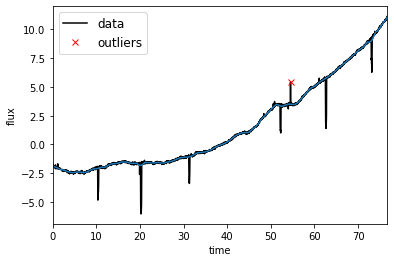

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (
    (np.arange(len(lc)) > 100)
    & np.isfinite(lc["FLUX"])
    & np.isfinite(lc["TIME"])
)
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from RadVel:

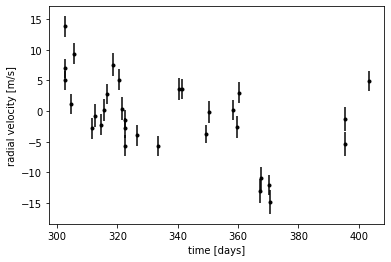

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

We can initialize the transit parameters using the box least squares periodogram from AstroPy. (Note: you’ll need AstroPy v3.1 or more recent to use this feature.) A full discussion of transit detection and vetting is beyond the scope of this tutorial so let’s assume that we know that there are two periodic transiting planets in this dataset.



In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let’s plot the initial transit estimates based on these periodograms:

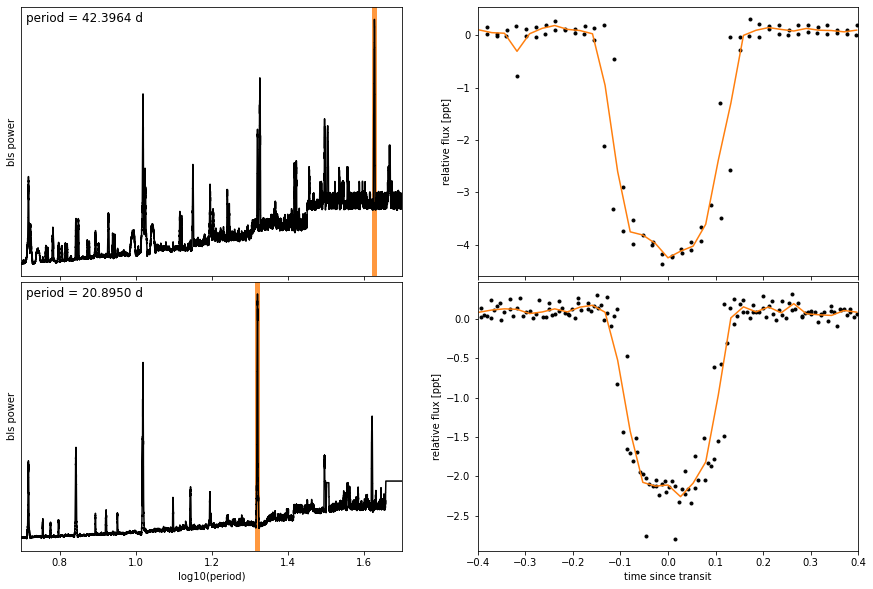

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

_ = fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 (Petigura et al. (2016)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.70019469 23.7162033 ] earthMass


A joint transit and radial velocity model in PyMC3

Now, let’s define our full model in PyMC3. There’s a lot going on here, but I’ve tried to comment it and most of it should be familiar from the other tutorials and case studies. In this case, I’ve put the model inside a model “factory” function because we’ll do some sigma clipping below.

In [9]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star_petigura[0], sd=M_star_petigura[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star_petigura[0], sd=R_star_petigura[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value), sd=1, shape=2)
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=2)
        log_r_pl = pm.Normal(
            "log_r_pl",
            mu=0.5 * np.log(1e-3 * np.array(depths))
            + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        period = pm.Deterministic("period", tt.exp(log_period))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.ImpactParameter("b", ror=ror, shape=2)

        ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
        )

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=5
        )
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0.0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit models
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = pm.Deterministic(
            "light_curves",
            xo.LimbDarkLightCurve(u_star).get_light_curve(
                orbit=orbit, r=r_pl, t=x[mask], texp=texp
            )
            * 1e3,
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("transit_obs", observed=resid)
        pm.Deterministic("gp_pred", gp.predict(resid))

        # And then include the RVs as in the RV tutorial
        x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())

        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_rv_ref, 3)
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic(
                "rv_model" + name, tt.sum(vrad, axis=-1) + bkg
            )

        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[trend])
        map_soln = pmx.optimize(start=map_soln, vars=[log_sigma_lc])
        map_soln = pmx.optimize(start=map_soln, vars=[log_r_pl, b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_rho_gp])
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]



message: Optimization terminated successfully.
logp: -8630.652446270726 -> -8617.487397600777
optimizing logp for variables: [log_sigma_lc]



message: Optimization terminated successfully.
logp: -8617.487397600777 -> 660.9459193319336
optimizing logp for variables: [b, log_r_pl, r_star]



message: Optimization terminated successfully.
logp: 660.9459193319336 -> 706.836524449466
optimizing logp for variables: [t0, log_period]



message: Optimization terminated successfully.
logp: 706.8365244494694 -> 761.9829163093549
optimizing logp for variables: [log_sigma_gp, log_sigma_lc]



message: Optimization terminated successfully.
logp: 761.9829163093552 -> 1451.8186561338832
optimizing logp for variables: [log_rho_gp]



message: Optimization terminated successfully.
logp: 1451.8186561338832 -> 1840.4664545992564
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, trend, log_sigma_rv, ecs, b, log_r_pl, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


In [ ]:
Now let’s plot the map radial velocity model.

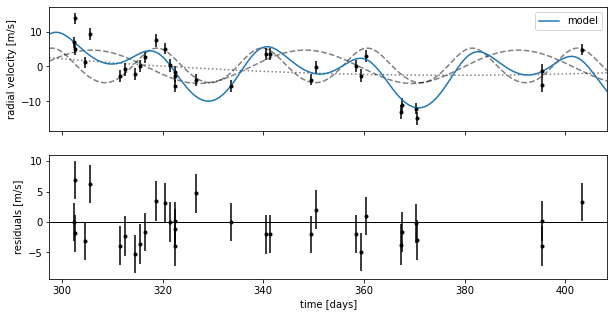

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


_ = plot_rv_curve(map_soln0)

In [ ]:
That looks pretty similar to what we got in the Radial velocity fitting tutorial. Now let’s also plot the transit model.

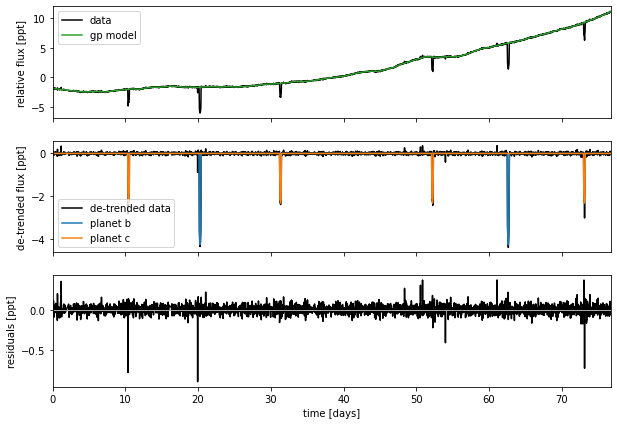

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0)


There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

Sigma clipping

To remove the outliers, we’ll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

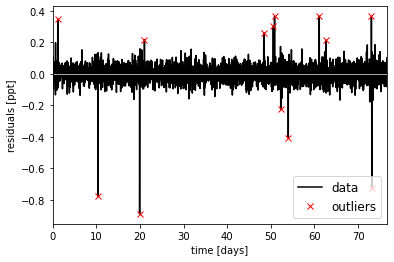

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
_ = plt.xlim(x.min(), x.max())

That looks better. Let’s re-build our model with this sigma-clipped dataset.

In [13]:
model, map_soln = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, mask)

optimizing logp for variables: [trend]



message: Optimization terminated successfully.
logp: 5187.757590280076 -> 5187.757590280076
optimizing logp for variables: [log_sigma_lc]



message: Optimization terminated successfully.
logp: 5187.757590280076 -> 5269.681393558104
optimizing logp for variables: [b, log_r_pl, r_star]



message: Optimization terminated successfully.
logp: 5269.681393558104 -> 5280.645007271359
optimizing logp for variables: [t0, log_period]



message: Optimization terminated successfully.
logp: 5280.645007271358 -> 5282.125494665054
optimizing logp for variables: [log_sigma_gp, log_sigma_lc]



message: Optimization terminated successfully.
logp: 5282.125494665063 -> 5282.85744116984
optimizing logp for variables: [log_rho_gp]



message: Optimization terminated successfully.
logp: 5282.85744116984 -> 5282.858700976481
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, trend, log_sigma_rv, ecs, b, log_r_pl, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


Great! Now we’re ready to sample.

Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer. This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter, eccentricity, and radius/radius ratio). It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that’s beyond the scope of this tutorial. Besides, using more traditional MCMC methods, this would have taken a lot longer to get thousands of effective samples!

In [ ]:
np.random.seed(203771098)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        initial_accept=0.8,
        target_accept=0.99,
        return_inferencedata=True,
    )

In [ ]:
Let’s look at the convergence diagnostics for some of the key parameters:

In [ ]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "period",
        "r_pl",
        "m_pl",
        "ecc",
        "omega",
        "b",
        "log_sigma_gp",
        "log_rho_gp",
    ],
)

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters. This is because of the correlations that I mentioned above:



In [ ]:
import corner

_ = corner.corner(trace, var_names=["b", "ecc", "r_pl"])

Phase plots

Finally, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from Petigura et al. (2016))

In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(
        flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :],
        axis=-1,
    )

    # Get the posterior median orbital parameters
    p = np.median(flat_samps["period"][n])
    t0 = np.median(flat_samps["t0"][n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(flat_samps["light_curves"][:, (n + 1) % 2, :], axis=-1)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(
        x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = np.percentile(
        flat_samps["light_curves"][inds, n, :], [16, 50, 84], axis=-1
    )
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(flat_samps["period"][n].values),
        np.std(flat_samps["period"][n].values),
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [ ]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(flat_samps["period"][n])
    t0 = np.median(flat_samps["t0"][n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(flat_samps["vrad"][:, (n + 1) % 2], axis=-1)
    other += np.median(flat_samps["bkg"], axis=-1)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        flat_samps["vrad_pred"][inds, n], [16, 50, 84], axis=-1
    )
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

We can also compute the posterior constraints on the planet densities.

In [ ]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(
    flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun ** 3
)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")